# Setup and Configuration

In [ ]:
# Importing Necessary Libraries
import os
import joblib
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Set random seed for reproducibility
seed = 50
np.random.seed(seed)

# Display settings for this notebook
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')
sns.set(style="whitegrid")

print("Setup complete.")


Setup complete.


# Data Generation

In [ ]:
# Hyperparameters for Data Generation

num_users = 1000  # Total number of users
num_records = 10000  # Total number of records
anomaly_rate = 0.05  # Percentage of records that are anomalies
success_login_rate = 0.95  # Percentage of login attempts that are successful
uncommon_ip_prob = 0.03  # Probability of an uncommon IP address being chosen
failed_attempt_limit = 5  # Threshold for failed login attempts to trigger an anomaly
behavioral_score_low = 40  # Lower threshold for behavioral score anomalies
behavioral_score_high = 120  # Upper threshold for behavioral score anomalies

In [ ]:
# Generating synthetic data

# Generate user IDs
user_ids = np.random.choice(range(1, num_users + 1), num_records)

# Generate timestamps over the last year
timestamps = pd.date_range(start=datetime.now() - timedelta(days=365), periods=num_records, freq='min')

# Simulating Login Successes
login_statuses = np.random.choice(['Success', 'Fail'], num_records, p=[success_login_rate, 1 - success_login_rate])

# Generate IP addresses
common_ips = [f'192.168.1.{i}' for i in np.random.randint(10, 100, 10)]
uncommon_ips = [f'10.10.10.{i}' for i in np.random.randint(1, 10, 3)]
total_ips = common_ips + uncommon_ips
probabilities = [(1 - uncommon_ip_prob) / len(common_ips)] * len(common_ips) + [uncommon_ip_prob / len(uncommon_ips)] * len(uncommon_ips)
ip_addresses = np.random.choice(total_ips, num_records, p=probabilities)

# Define possible device types
device_types = ['Desktop', 'Mobile', 'Tablet']
devices = np.random.choice(device_types, num_records)

# Define normal Locations
locations = np.random.choice(['USA', 'Canada', 'Germany', 'Japan', 'Antarctica', 'Mars'], num_records, p=[0.24, 0.24, 0.24, 0.24, 0.02, 0.02])

# Generate session durations and behavioral scores
session_durations = np.where(login_statuses == 'Success', np.random.exponential(scale=300, size=num_records), 0)
failed_attempts = np.where(login_statuses == 'Fail', np.random.poisson(lam=2, size=num_records), 0)
behavioral_scores = np.where(login_statuses == 'Success', np.random.normal(loc=80, scale=10, size=num_records), np.random.normal(loc=50, scale=10, size=num_records))

# Define anomalies based on specific conditions
anomaly_conditions = (
    (failed_attempts > failed_attempt_limit) |
    (behavioral_scores < behavioral_score_low) |
    (behavioral_scores > behavioral_score_high) |
    (session_durations > 3 * np.mean(session_durations)) |
    (session_durations < 5) |
    (np.isin(ip_addresses, uncommon_ips)) |
    (np.isin(locations, ['Antarctica', 'Mars']))
)
anomaly_labels = anomaly_conditions.astype(int)

# Compile all features into a DataFrame
df = pd.DataFrame({
    'User ID': user_ids,
    'Timestamp': timestamps,
    'Login Status': login_statuses,
    'IP Address': ip_addresses,
    'Device Type': devices,
    'Location': locations,
    'Session Duration': session_durations,
    'Failed Attempts': failed_attempts,
    'Behavioral Score': behavioral_scores,
    'Anomaly': anomaly_labels
})

# Save the DataFrame to the data directory
os.makedirs('data', exist_ok=True)
file_path = os.path.join('data', 'synthetic_web_auth_logs.csv')
df.to_csv(file_path, index=False)
print(f"Data saved successfully to '{file_path}'.")

df.head()

Data saved successfully to 'data/synthetic_web_auth_logs.csv'.


,User ID,Timestamp,Login Status,IP Address,Device Type,Location,Session Duration,Failed Attempts,Behavioral Score,Anomaly
0,689,2024-10-12 08:10:06.120877,Success,192.168.1.14,Desktop,Canada,7.439981,0,88.550647,0
1,481,2024-10-12 08:11:06.120877,Success,192.168.1.25,Mobile,Germany,400.523324,0,92.295306,0
2,908,2024-10-12 08:12:06.120877,Success,192.168.1.54,Tablet,Canada,298.019279,0,81.044294,0
3,110,2024-10-12 08:13:06.120877,Success,192.168.1.27,Mobile,USA,0.020560,0,97.926740,1
4,290,2024-10-12 08:14:06.120877,Success,192.168.1.27,Mobile,Germany,409.528331,0,71.393190,0


# Data Exploration

In [ ]:
# Checking for missing values and basic info
df.info()
print("\nMissing values in each column:\n", df.isnull().sum())
print("\nDescriptive Statistics by Anomaly Status:")
print(df.groupby('Anomaly').describe())

# Check the balance of anomalies
print("\nAnomaly Ratio (%):")
print(df['Anomaly'].value_counts(normalize=True) * 100)

# Check relationships between features
df_temp = df.copy()  # Create a temporary copy of the DataFrame
df_temp['Login Status'] = df_temp['Login Status'].map({'Success': 1, 'Fail': 0})
correlation_matrix = df_temp.select_dtypes(include=[np.number]).corr()
print("\nCorrelation Matrix of all features:\n", correlation_matrix)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   User ID           10000 non-null  int64         
 1   Timestamp         10000 non-null  datetime64[ns]
 2   Login Status      10000 non-null  object        
 3   IP Address        10000 non-null  object        
 4   Device Type       10000 non-null  object        
 5   Location          10000 non-null  object        
 6   Session Duration  10000 non-null  float64       
 7   Failed Attempts   10000 non-null  int64         
 8   Behavioral Score  10000 non-null  float64       
 9   Anomaly           10000 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 781.4+ KB

Missing values in each column:
 User ID             0
Timestamp           0
Login Status        0
IP Address          0
Device Type         0
Location          

# Data Visualization

/tmp/ipython-input-708689066.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Anomaly', y=feature, data=df, palette={'0': 'skyblue', '1': 'salmon'})


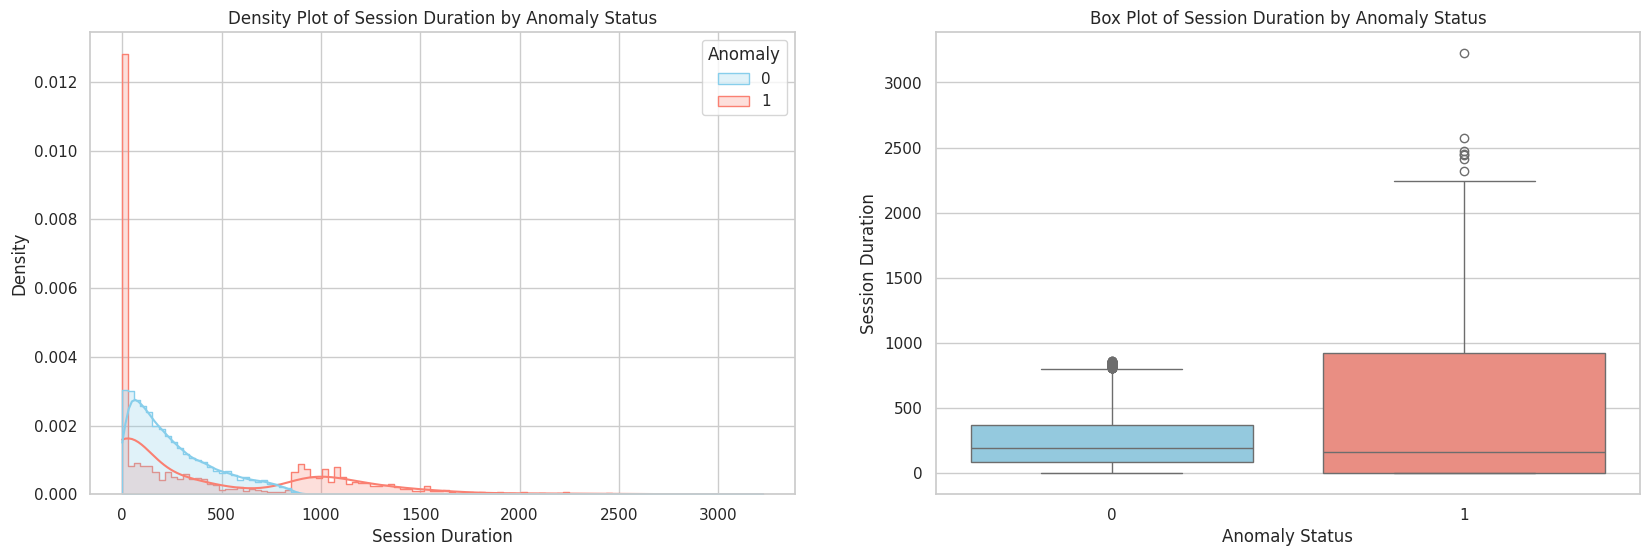

/tmp/ipython-input-708689066.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Anomaly', y=feature, data=df, palette={'0': 'skyblue', '1': 'salmon'})


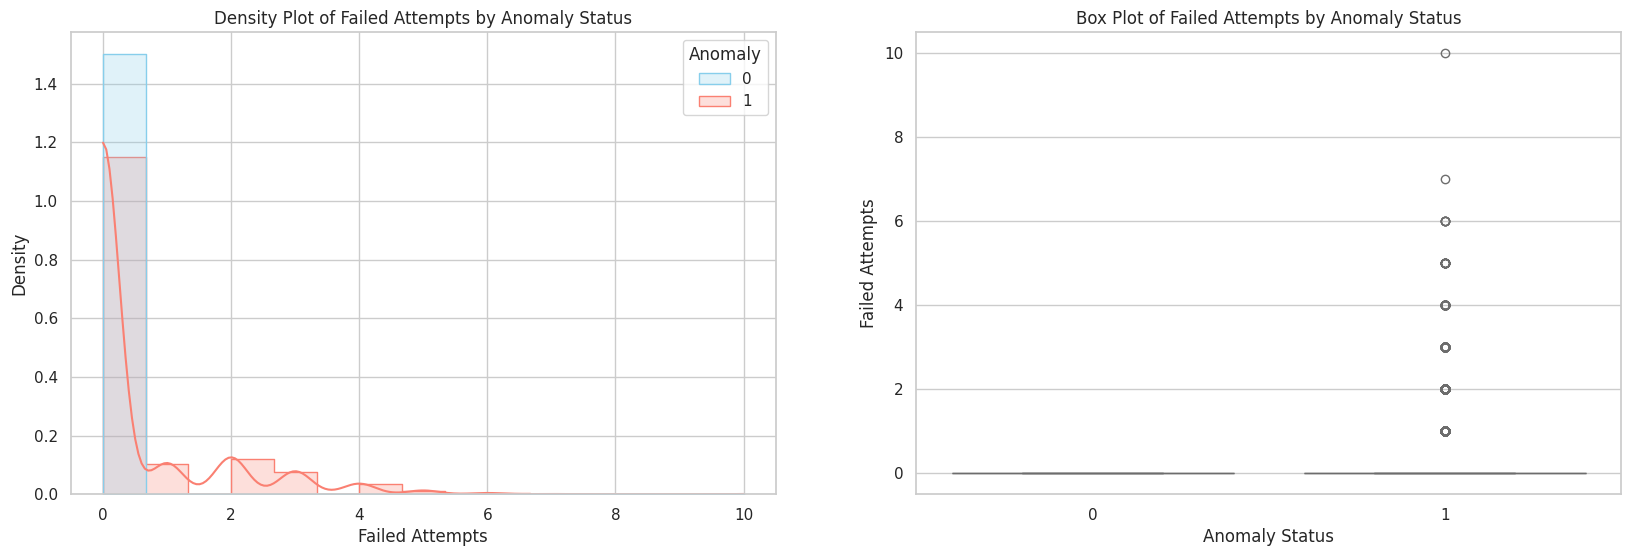

/tmp/ipython-input-708689066.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Anomaly', y=feature, data=df, palette={'0': 'skyblue', '1': 'salmon'})


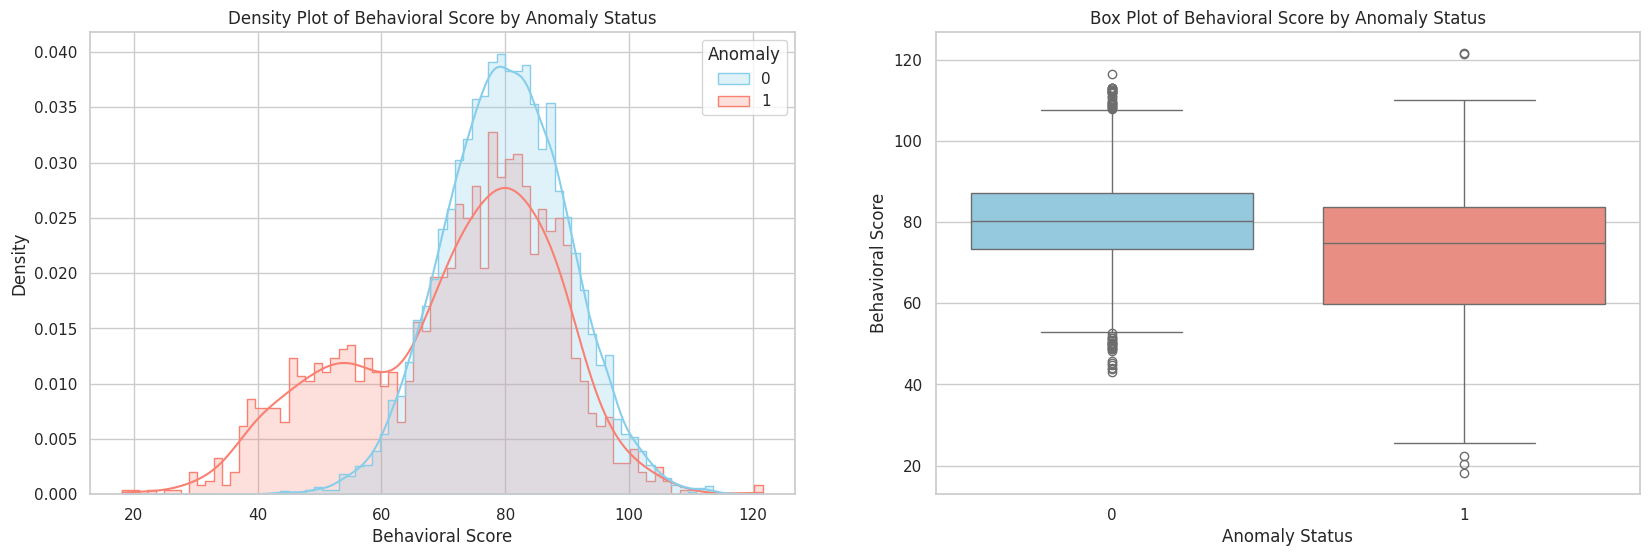

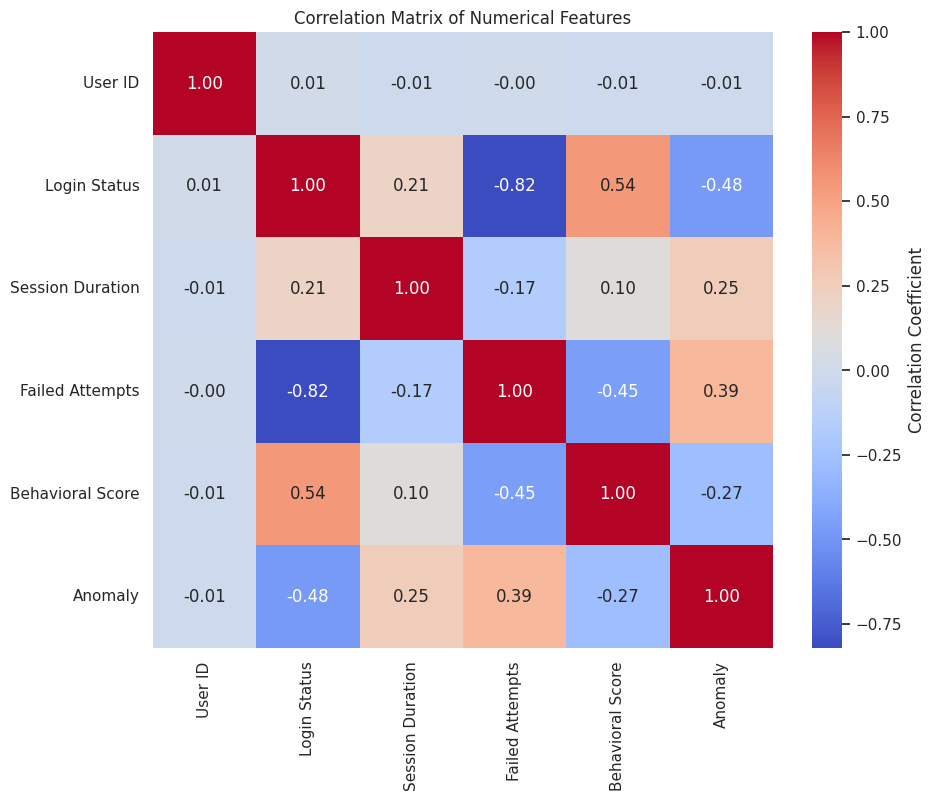

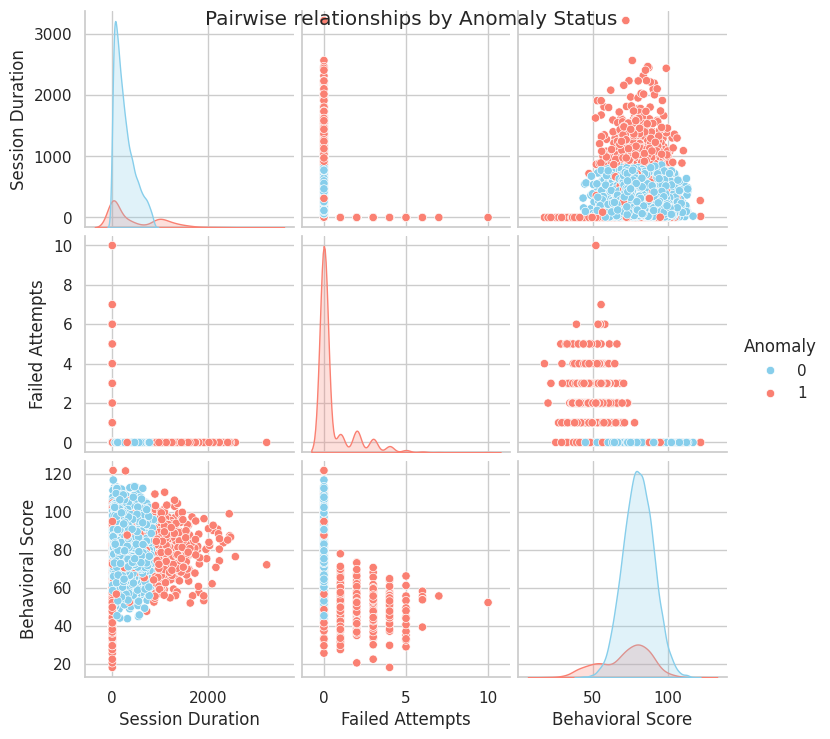

In [ ]:
# Visualization

# Density and box plots for numerical features by anomaly status
numerical_features = ['Session Duration', 'Failed Attempts', 'Behavioral Score']
for feature in numerical_features:
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)  # Density plot
    sns.histplot(data=df, x=feature, hue='Anomaly', element='step', stat='density', common_norm=False, kde=True, palette={0: 'skyblue', 1: 'salmon'})
    plt.title(f'Density Plot of {feature} by Anomaly Status')
    plt.xlabel(feature)
    plt.ylabel('Density')

    plt.subplot(1, 2, 2)  # Box plot
    sns.boxplot(x='Anomaly', y=feature, data=df, palette={'0': 'skyblue', '1': 'salmon'})
    plt.title(f'Box Plot of {feature} by Anomaly Status')
    plt.xlabel('Anomaly Status')
    plt.ylabel(feature)
    plt.show()

# Heatmap for the correlation matrix of numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Pairplot for pairwise relationships, segmented by Anomaly status
sns.pairplot(df, hue='Anomaly', vars=numerical_features, palette={0: 'skyblue', 1: 'salmon'})
plt.suptitle('Pairwise relationships by Anomaly Status', verticalalignment='top')
plt.show()

# Data Preprocessing

This section covers the preparation of the dataset. Different preprocessing steps are applied to numerical and categorical features to ensure they are appropriately formatted for the machine learning models.

In [ ]:
# Define pipelines for numerical and categorical features
numerical_features = ['Session Duration', 'Failed Attempts', 'Behavioral Score']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_features = ['Device Type', 'Location', 'Login Status', 'IP Address']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

def extract_time_features(x):
    x['hour'] = x['Timestamp'].dt.hour
    x['day_of_week'] = x['Timestamp'].dt.dayofweek
    return x[['hour', 'day_of_week']]
time_transformer = Pipeline(steps=[
    ('time_features', FunctionTransformer(extract_time_features, validate=False)),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('time', time_transformer, ['Timestamp'])
    ])

# Splitting the data into training and testing sets and apply transformations
x = df.drop('Anomaly', axis=1)
y = df['Anomaly']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)
x_train_prepared = preprocessor.fit_transform(x_train)
x_test_prepared = preprocessor.transform(x_test)


# Model Training and Evaluation

This section focuses on training various machine learning models on the preprocessed data and evaluating their performance to assess the efficacy of each model in distinguishing between normal and anomalous activities.


## Models Training

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(C=10, max_iter=1000, class_weight='balanced'),
    'SVM': SVC(C=10, probability=True, class_weight='balanced')
}
model_predictions = {}
for name, model in models.items():
    model.fit(x_train_prepared, y_train)
    predictions = model.predict(x_test_prepared)
    probabilities = model.predict_proba(x_test_prepared)[:, 1]
    model_predictions[name] = {
        'predictions': predictions,
        'probabilities': probabilities
    }
    print(f"{name} trained successfully.")

    pipeline = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('model', model)
    ])

    # Export model to pkl
    filename = f"{name.lower().replace(' ', '_')}_pipeline.pkl"
    joblib.dump(pipeline, filename)
    print(f"Exported {name} → {filename}")

Logistic Regression trained successfully.
Exported Logistic Regression → logistic_regression_pipeline.pkl
SVM trained successfully.
Exported SVM → svm_pipeline.pkl


## Models Evaluation

Evaluation Results for Logistic Regression:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1653
           1       0.85      0.90      0.87       347

    accuracy                           0.95      2000
   macro avg       0.91      0.93      0.92      2000
weighted avg       0.96      0.95      0.96      2000



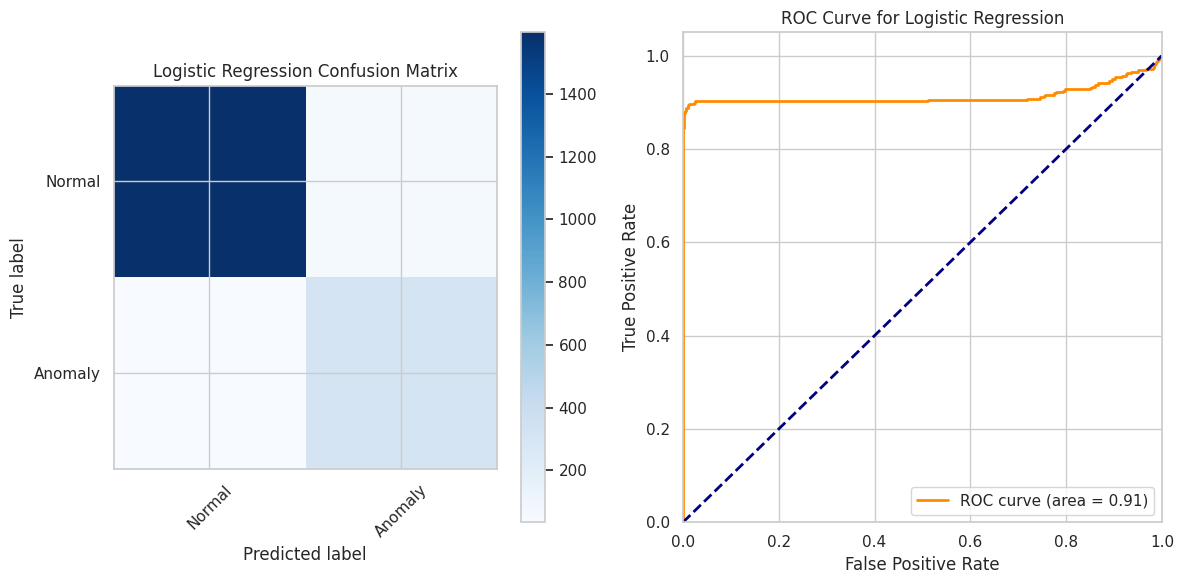

Evaluation Results for SVM:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1653
           1       0.92      0.92      0.92       347

    accuracy                           0.97      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.97      0.97      0.97      2000



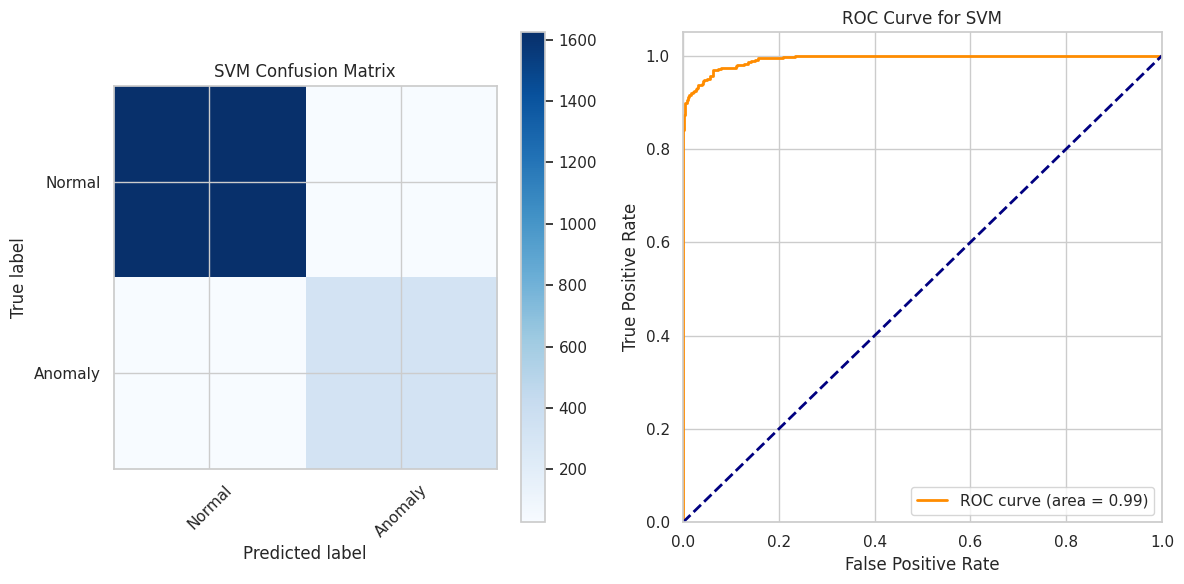

Best performing model: SVM with ROC AUC = 0.99


In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.subplot(1, 2, 1)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.xticks(np.arange(len(classes)), classes, rotation=45)
    plt.yticks(np.arange(len(classes)), classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_roc_curve(fpr, tpr, model, roc_auc):
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model}')
    plt.legend(loc="lower right")

# Evaluate each model
for name, outcomes in model_predictions.items():
    print(f"Evaluation Results for {name}:")
    print(classification_report(y_test, outcomes['predictions']))
    cm = confusion_matrix(y_test, outcomes['predictions'])
    fpr, tpr, _ = roc_curve(y_test, outcomes['probabilities'])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(12, 6))
    plot_confusion_matrix(cm, classes=['Normal', 'Anomaly'], title=f'{name} Confusion Matrix')
    plot_roc_curve(fpr, tpr, name, roc_auc)
    plt.tight_layout()
    plt.show()

# Collect and compare ROC AUC scores
roc_auc_scores = {name: auc(roc_curve(y_test, outcomes['probabilities'])[0],
                             roc_curve(y_test, outcomes['probabilities'])[1])
                  for name, outcomes in model_predictions.items()}
best_model = max(roc_auc_scores, key=roc_auc_scores.get)
print(f"Best performing model: {best_model} with ROC AUC = {roc_auc_scores[best_model]:.2f}")